In [107]:
import os
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import math

In [16]:
def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [17]:
train = load_df()
test = load_df("test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


In [48]:
train['totals.transactionRevenue'].fillna(0, inplace = True)

In [54]:
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].astype(float)

In [58]:
train['data_source'] = 'train'
test['data_source'] = 'test'

all_data = pd.concat([train,test], axis = 0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


### Finding columns with only one value in it or those that have 50% data missing

In [71]:
drop_columns = [each for each in all_data.columns if len(train[each].unique()) <= 2 or all_data[each].isnull().sum() > 0.5 * all_data.shape[0]]
drop_columns = [each for each in drop_columns if each not in ['totals.transactionRevenue','data_source']]

In [76]:
all_data_upd = all_data.drop(drop_columns, axis = 1)

### Inserting date columns

In [78]:
all_data_upd['year'] = all_data_upd.date.apply(lambda x: int(str(x)[0:4]))
all_data_upd['month'] = all_data_upd.date.apply(lambda x: int(str(x)[4:6]))
all_data_upd['day'] = all_data_upd.date.apply(lambda x: int(str(x)[6:8]))

In [80]:
train_upd = all_data_upd[all_data_upd.data_source == 'train']
test_upd = all_data_upd[all_data_upd.data_source == 'test']

### Popular browsers:

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

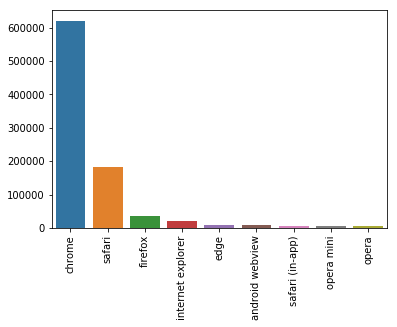

In [149]:
counts = train_upd['device.browser'].value_counts()[train_upd['device.browser'].value_counts() > 5000].values
categories = train_upd['device.browser'].value_counts()[train_upd['device.browser'].value_counts() > 5000].index
sns.barplot(x = categories, y = counts)
plt.xticks(rotation=90)

### Devices used for revenue > 0:

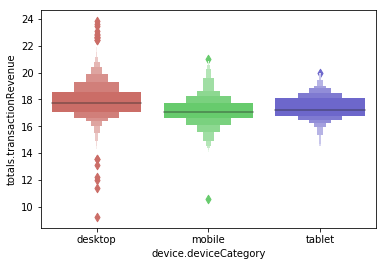

In [158]:
p = sns.boxenplot(train_upd['device.deviceCategory'], np.log(train_upd['totals.transactionRevenue'][train_upd['totals.transactionRevenue']>0]), palette = 'hls')

### Most common operating systems:

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

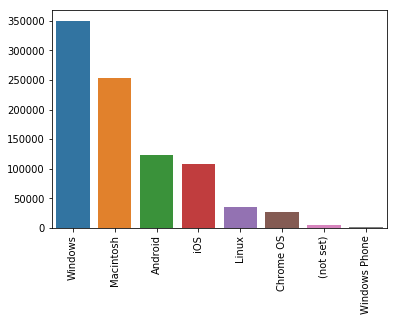

In [118]:
counts = train_upd['device.operatingSystem'].value_counts()[train_upd['device.operatingSystem'].value_counts() > 1000].values
categories = train_upd['device.operatingSystem'].value_counts()[train_upd['device.operatingSystem'].value_counts() > 1000].index
sns.barplot(x = categories, y = counts)
plt.xticks(rotation=90)

### Common continents:

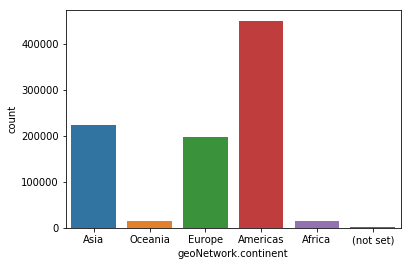

In [130]:
p = sns.countplot(train_upd['geoNetwork.continent'])

### What months lead to most revenue?

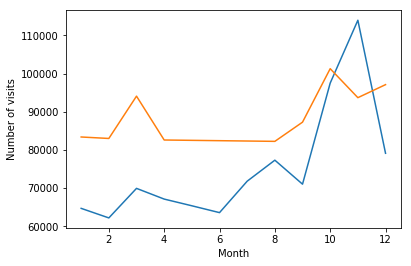

In [153]:
p = sns.lineplot(train_upd['month'].value_counts().index, train_upd['month'].value_counts().values)
p = sns.lineplot(test_upd['month'].value_counts().index, test_upd['month'].value_counts().values)
p = p.set(xlabel='Month', ylabel='Number of visits')